# Import data

In [ ]:
# convert the raw yelp file to a big list of reviews
from json import loads

def yelpfeed_to_reviews(in_fname, out_fname):
    with open(in_fname, 'r') as f:
        with open(out_fname, 'w') as g:
            for i, line in enumerate(f):
                try:
                    print '\r{}'.format(i),
                    data = loads(line)
                    for review in data['reviews']:
                        g.write(review['text']+'\n')
                except:
                    pass
            
yelpfeed_to_reviews('../data/yelp_businesses.json', '../data/yelp_reviews')

In [1]:
from twokenize import tokenize

In [2]:
# bring in all tweets training data and format as sentences
data_fname = '../wnut_ner_evaluation/data/train_notypes'
xs, ys = [], []
with open(data_fname, 'r') as f:
    x, y = [], []
    for i, line in enumerate(f):
        split = line.split()
        if split:
            x.append(split[0])
            y.append(split[1])
        else: 
            xs.append(x)
            ys.append(y)
            x, y = [], []

In [3]:
# bring in all of the raw yelp reviews
# tokenize them all with twokenize
# convert them to sentences and add to the data
for i, line in enumerate(open('../data/yelp_reviews', 'r')):
    print '\r{}'.format(i),
    x = tokenize(line)
    if x:
        xs.append(x)

2527752


In [20]:
""" A convenience vocabulary wrapper """
from collections import Counter
import numpy as np
import numpy.random as npr

class Vocab():
    def __init__(self, all_tokens=None, min_count=5):
        self.min_count=min_count
        self.count_index = Counter()
        self._vocab2idx = {'<PAD>':0,
                           '<UNK>':1}
        self._idx2vocab = {0:'<PAD>',
                           1:'<UNK>'}
        self.vocabset = set(self._vocab2idx.keys())
        self.idxset = set(self._idx2vocab.keys())
        
        if all_tokens:
            self.use(all_tokens)

        self._n = sum( count for count in self.count_index.values() if count >= self.min_count)
        self._v = sum( 1 for count in self.count_index.values() if count >= self.min_count)

        self.make_sampling_table()
        
    @property
    def n(self):
        return self._n    

    @property
    def v(self):
        return self._v

    @property
    def pad(self):
        return '<PAD>'
    
    @property
    def ipad(self):
        return 0
    
    def idx(self, token):
        if token in self.vocabset:
            return self._vocab2idx[token]
        else:
            return self._vocab2idx['<UNK>']
        
    def token(self, idx):
        if idx in self.idxset:
            return self._idx2vocab[idx]
        else:
            return self._idx2vocab['<UNK>']
    
    def use(self, tokens):
        self.count_index = Counter()
        self.add(tokens)        
    
    def add(self, tokens):
        for token in tokens:
            self.count_index[token] += 1
        self._vocab2idx = {'<UNK>':0}
        self._vocab2idx.update({token:i+1 for i, (token, count) in enumerate(self.count_index.most_common())
                                if count >= self.min_count})
        self._idx2vocab = {i:token for token, i in self._vocab2idx.items()}
        self.vocabset = set(self._vocab2idx.keys())
        self.idxset = set(self._idx2vocab.keys())
        self._n = sum( count for count in self.count_index.values() if count >= self.min_count)
        self._v = sum( 1 for count in self.count_index.values() if count >= self.min_count)
        
    def count(self, token):
        return self.count_index[token]

    def make_sampling_table(self, power_scalar=.75):
        # from 0 to V-1, get the frequency
        self.vocab_distribution = np.array([ (self.count_index[self._idx2vocab[idx]]/float(self._n))**power_scalar
                                    for idx in range(len(self.idxset))])
        self.vocab_distribution /= np.sum(self.vocab_distribution)

    def sample(self, sample_shape):
        # sample a tensor of indices
        # by walking up the CDF
        # setting each position to the index
        # of the word which is the closest
        # word with that CDF
        sums = np.zeros(sample_shape)
        rands = npr.uniform(size=sample_shape)
        idxs = np.zeros(sample_shape)
        for i in range(len(self.vocab_distribution)):
            sums += self.vocab_distribution[i]
            new = sums <= rands
            if np.any(new):
                idxs[new] = i
            else:
                break
        return idxs.astype(np.int)

In [21]:
all_tokens = ( word for x in xs for word in x )
vocab = Vocab(all_tokens, min_count=5)

In [22]:
print vocab.v

86077


In [23]:
from matplotlib import pyplot as plt
import numpy as np

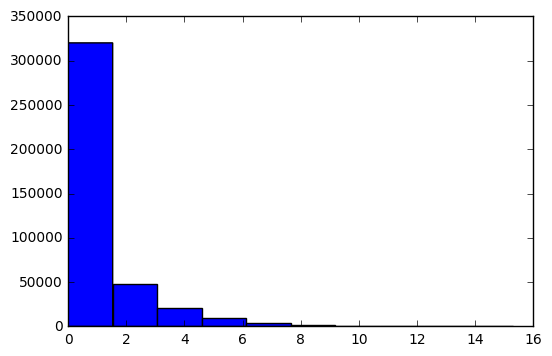

In [24]:
plt.hist(np.log(vocab.count_index.values()), 10)
plt.show()

In [25]:
from preprocess import *

In [26]:
def index_to_sequence(sentence, vocab):
    return [ vocab.token(token) for token in sentence ]

def indices_to_sequences(sentences, vocab):
    return [ index_to_sequence(sentence, vocab) for sentence in sentences ]

In [27]:
# from preprocess import *
# all_chargrams = ( c for x in xs for g in chargrams(x) for c in g )
# xvocab = Vocab(all_chargrams, min_count=5)
# print xvocab.v

# Create the skipgrams

In [28]:
# drop any words not in vocab
import numpy.random as npr
small_xs = [ [ word for word in x if word in vocab.vocabset ] for x in npr.choice(xs, 5000, replace=False) ]

In [29]:
k = 3
n = 3
targets, pos = [], []
for a, x in enumerate(small_xs):
    print '\r{}'.format(a),
    L = len(x)
    for i in range(L):
        for j in range(1,k+1):
            if i-j >= 0:
                targets.append(x[i])
                pos.append(x[i-j])
            if i+j < L:
                targets.append(x[i])
                pos.append(x[i+j])

4999


In [34]:
samples = vocab.sample([len(targets), n]).tolist()

KeyboardInterrupt: 

In [39]:
samples = npr.choice(np.arange(len(vocab.vocab_distribution)), 
                     p=vocab.vocab_distribution,
                     size=[len(targets), n]).tolist()

In [40]:
print len(samples)

1342150


In [41]:
negs = indices_to_sequences(samples, vocab)

In [42]:
print len(targets), len(pos), len(negs)

1342150 1342150 1342150


In [44]:
with open('skipgrams.txt', 'w') as f:
    for i, (t,p, n) in enumerate(zip(targets, pos, negs)):
        s = " ".join([t]+[p]+n)
        if i < 10:
            print s
        f.write(s+'\n')

This place MUCH not We
This has with available Swiss
This some in tso's Always
place This sushis If Hahahaha
place has laughing were special
place some trader t-t .
place to ( Lover's restaurant
has place looked speak cheap
has some ink I She
has This problem anybody's while


In [60]:
from tfmodel import *

class Word2Vec(TFModel):
    def build_forward(self):
        self.word = tf.placeholder(tf.int32, [None])
        self.pos = tf.placeholder(tf.int32, [None])
        self.negs = [ tf.placeholder(tf.int32, [None]) for _ in xrange(self.n_neg) ]
        
        self.word_vectors = tf.Variable(tf.random_uniform([self.vocab.v, self.word_embed_size],
                                                          -.1, .1, tf.float32))
        self.context_vectors = tf.Variable(tf.random_uniform([self.vocab.v, self.word_embed_size],
                                                          -.1, .1, tf.float32))
        
        self.embedded_word = tf.nn.embedding_lookup(self.word_vectors, self.word)
        self.embedded_pos = tf.nn.embedding_lookup(self.context_vectors, self.pos)
        self.embedded_negs = [ tf.nn.embedding_lookup(self.context_vectors, neg) for neg in self.negs ]
        
    def build_loss(self):
        pos_loss = tf.nn.sigmoid(tf.reduce_sum(self.embedded_word * self.embedded_pos, [1]))
        neg_loss = (1./self.n_neg) * tf.add_n([
                tf.nn.sigmoid(-tf.reduce_sum(self.embedded_word * neg, [1]))
                for neg in self.embedded_negs])
        self.loss = tf.reduce_mean(pos_loss + neg_loss)
        
    def build_optimizer(self):
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)
        
    def partial_fit(self, x, y, measure_only=False):
        pos, negs = zip(*y)
        feed_dict = {
            self.word:x,
            self.pos:pos
        }
        feed_dict.update({neg:n for neg,n in zip(self.negs, negs[0])})
        if measure_only:
            loss = self.session.run(self.loss, feed_dict)
        else:
            loss, _ = self.session.run([self.loss, self.train_op], feed_dict)
        return loss
    
    def predict(self, x):
        pass
    
    def save_vectors(self, fname):
        vectors = self.session.run(self.word_vectors)
        with open(fname, 'w') as f:
            for i in xrange(self.vocab.v):
                vec = vectors[i].tolist()
                word = self.vocab.token(i)
                f.write(' '.join([word]+vec)+'\n')

In [61]:
tf.reset_default_graph()
session = tf.InteractiveSession()

params = {
    'vocab':vocab,
    'n_neg':3,
    'learning_rate':.001,
    'word_embed_size':50
}

w2v = Word2Vec(session, **params)

Model Loading... Done


In [63]:
x = sequence_to_index(targets, vocab)
py = sequence_to_index(pos, vocab)
ny = sequences_to_indices(negs, vocab)

In [79]:
ny[:2][0]

[4540, 27, 78]

In [83]:
zip(py, zip(ny))[0][1][0]

[4540, 27, 78]

In [66]:
w2v.fit(x, zip(py, zip(ny)))

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_3' with dtype int32
	 [[Node: Placeholder_3 = Placeholder[dtype=DT_INT32, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op u'Placeholder_3', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-3e018dc09eca>", line 11, in <module>
    w2v = Word2Vec(session, **params)
  File "tfmodel.py", line 14, in __init__
    self.build_forward()
  File "<ipython-input-60-29327765614b>", line 7, in build_forward
    self.negs = [ tf.placeholder(tf.int32, [None]) for _ in xrange(self.n_neg) ]
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1212, in placeholder
    name=name)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1530, in _placeholder
    name=name)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2317, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/thomaseffland/.virtualenvs/twitter/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1239, in __init__
    self._traceback = _extract_stack()
